<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/ordinary_kriging/kriging/ordinary_kriging_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
!pip install earthengine-api geemap geopandas geobr rtree pyproj rasterio contextily descartes -q

In [191]:
!pip install pykrige -q

In [192]:
## Import packages
import rasterio as rio
from rasterio.transform import Affine
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
import contextily as cx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geemap
import json
import seaborn as sns
from shapely.geometry import Point
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [193]:
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
PROJECT_BASE = f"{GDRIVE_BASE}/MyDrive/amazon_rainforest_files"
# From PROJECT_BASE root
DATASET_PATH = "amazon_sample_data/luis_train_random_ungrouped.csv" #@param
# From PROJECT_BASE root
BIOME_PATH = "christian_files/lm_bioma_250.shp" #@param
# From PROJECT_BASE root
OUTPUT_ISOSCAPE_PATH_MEANS = "amazon_rasters/uc_davis_d18O_cel_means_random_ungrouped.tiff" #@param
# From PROJECT_BASE root
OUTPUT_ISOSCAPE_PATH_VARS = "amazon_rasters/uc_davis_d18O_cel_vars_random_ungrouped.tiff" #@param
ISOTOPE_MEAN_COLUMN_NAME = "d18O_cel_mean" #@param
ISOTOPE_VARIANCE_COLUMN_NAME = "d18O_cel_variance" #@param

In [194]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
# Function to convert result to raster file
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [196]:
# Load coordinates and values from dataset path.
df = pd.read_csv(f"{PROJECT_BASE}/{DATASET_PATH}").dropna(subset=['lat', 'long', ISOTOPE_MEAN_COLUMN_NAME, ISOTOPE_VARIANCE_COLUMN_NAME])
x = df['long'].values.reshape(-1, 1)
y = df['lat'].values.reshape(-1, 1)
z_means = df[ISOTOPE_MEAN_COLUMN_NAME].values.reshape(-1, 1)
z_vars = df[ISOTOPE_VARIANCE_COLUMN_NAME].values.reshape(-1, 1)

In [197]:
# Load Amazon geometry dataset that'll be used to mask isoscape in expected shape.
amazon_biome_path = f"{PROJECT_BASE}/{BIOME_PATH}"
gdf_amazon = gpd.read_file(amazon_biome_path)
gdf_amazon = gdf_amazon[gdf_amazon.Bioma=='AmazÃ´nia']

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [198]:
# RasterIO projection configuration used to create raster from isoscape from interpolation.
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "

In [199]:
def create_isoscape_ordinary_kriging(
    gdf_amazon: gpd.GeoDataFrame,
    x: float,
    y: float,
    z: float,
    proj: str,
    out_filename: str
):
  '''
  Creates an isoscape for a gdf_amazon with values projected from fitted
  Ordinary Kriging model on the coordinates x, y and z
  using the configuration proj for the raster.
  '''
  min_x, min_y, max_x, max_y = gdf_amazon.total_bounds
  XX_pk_krig = np.linspace(min_x, max_x, 235)
  YY_pk_krig  = np.linspace(min_y, max_y, 234)

  ok = OrdinaryKriging(
      x,
      y,
      z,
      variogram_model="linear",
      verbose=False,
      enable_plotting=True,
      enable_statistics=True,
      coordinates_type='geographic',
      pseudo_inv=True # this leads to more numerical stability and redundant
                      # points are averaged. This prevents singular matrix
                      # errors which happens frequently with variance isoscape
                      # in this method.
  )

  Z_pk_krig, sigma_squared_p_krig  = ok.execute("grid", XX_pk_krig, YY_pk_krig)
  ok.print_statistics()

  export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x, max_x = max_x, min_y = min_y, max_y = max_y,
                  proj = proj, filename = out_filename)

  return XX_pk_krig, YY_pk_krig, Z_pk_krig, sigma_squared_p_krig

In [200]:
def display_isoscape(filename, gdf_amazon):
  '''
  Given a filename to a RasterIO file containing an isoscape raster,
  display the isoscape masked by the gdf_amazon geomtry.
  '''
  raster_pk = rasterio.open(filename)

  out_image_pk, out_transform_pk = rio.mask.mask(raster_pk, gdf_amazon.geometry.values, crop = True)

  fig, ax = plt.subplots(1, figsize = (10, 10))
  show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdYlGn")

  plt.gca().invert_yaxis()
  plt.show()

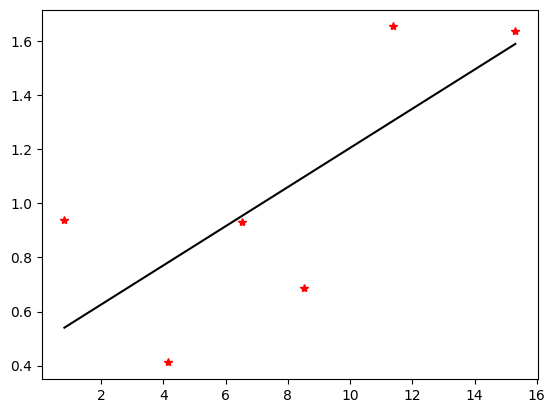

Q1 = 0.15281294020690234
Q2 = 2.145754308985044
cR = 1.2409578256986535


In [201]:
XX_pk_krig, YY_pk_krig, Z_pk_krig, sigma_squared_p_krig = create_isoscape_ordinary_kriging(gdf_amazon, x, y, z_means, proj,
                                                                                           f"{PROJECT_BASE}/{OUTPUT_ISOSCAPE_PATH_MEANS}")

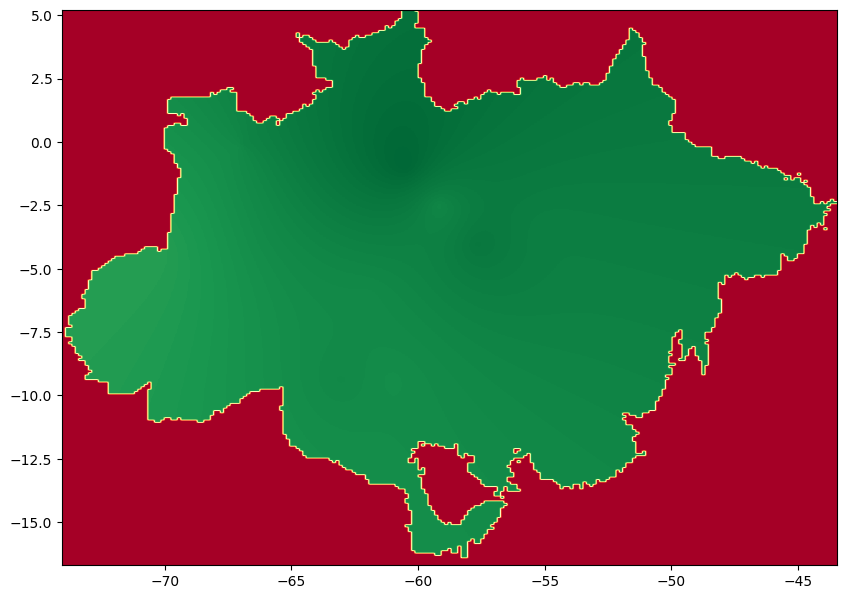

In [202]:
filename = f"{PROJECT_BASE}/{OUTPUT_ISOSCAPE_PATH_MEANS}"
display_isoscape(filename, gdf_amazon)

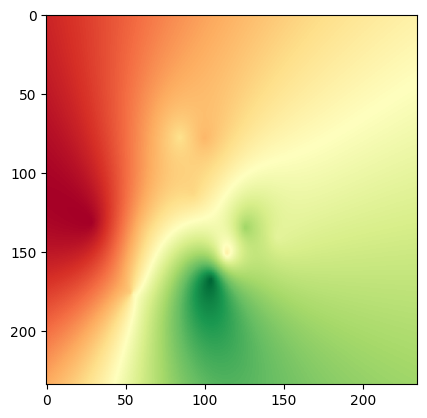

In [203]:
# Gridded data to ASCII grid file

kt.write_asc_grid(XX_pk_krig, YY_pk_krig, Z_pk_krig, filename="output.asc",no_data=-999.0, style=1)
plt.imshow(Z_pk_krig,cmap = "RdYlGn" )
plt.show()

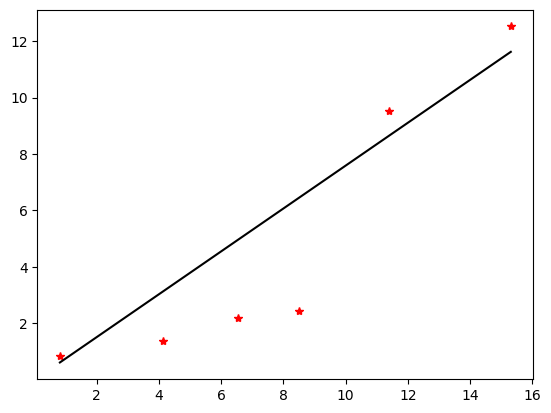

Q1 = 0.06911703166167904
Q2 = 961.6318300646932
cR = 14.924783021023142


In [204]:
XX_pk_krig, YY_pk_krig, Z_pk_krig, sigma_squared_p_krig = create_isoscape_ordinary_kriging(gdf_amazon, x, y, z_vars, proj,
                                                                                           f"{PROJECT_BASE}/{OUTPUT_ISOSCAPE_PATH_VARS}")

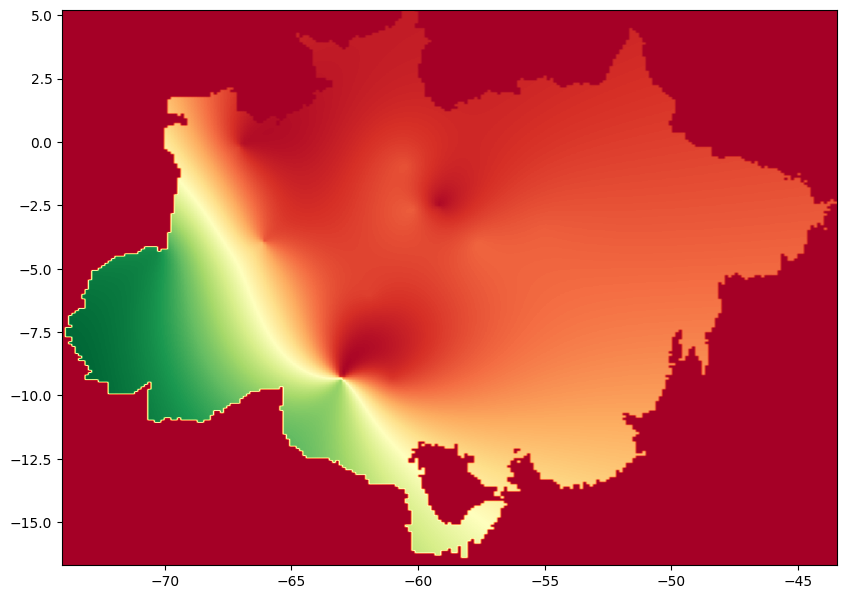

In [205]:
filename = f"{PROJECT_BASE}/{OUTPUT_ISOSCAPE_PATH_VARS}"
display_isoscape(filename, gdf_amazon)

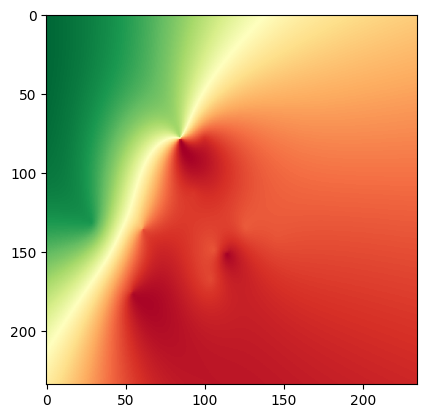

In [206]:
# Gridded data to ASCII grid file

kt.write_asc_grid(XX_pk_krig, YY_pk_krig, Z_pk_krig, filename="output.asc",no_data=-999.0, style=1)
plt.imshow(Z_pk_krig,cmap = "RdYlGn" )
plt.show()